This notebook is intended to be used as a simple example of pytorch for an upcoming 3rd grade presenation.   The code will build a simple dense neural network in order to classify images from the CIFAR 10 dataset.

To make this notebook work, please download anaconda on your machine: https://www.anaconda.com/distribution/

Then create a virtual environment with pytorch by using the following commands: <i>
    
    conda create --name CIFAR10 python=3.7 
    python -m ipykernel install --user --name CIFAR10 --display-name "CIFAR10 - Python (3.7)" 
    conda activate CIFAR10 
    conda install pytorch torchvision cudatoolkit=10.0 -c pytorch 
    conda install matplotlib jupyter 
    git clone https://github.com/jacobffjensen/MiamiData2019.git 
    jupyter notebook

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline   

In [2]:
# Build a simple 2 layer linear model for classifying digits:
#   input - 32x32 grayscale photo
#   output - a prediction of which type of object is detected in the image
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.Linear(32*32*3,100)
        self.L2 = nn.Linear(100,10)
        self.D1 = nn.Dropout(0.2)
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = F.relu(self.L1(x))
        x = self.D1(x)
        x = self.L2(x)
        x = F.log_softmax(x,dim=1)
        return x

In [3]:
# Select how many photos to train in one go
batch_size=64

# Modify each photo before passing into neural network
transform = transforms.Compose([
                                #transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download photos and create data loaders for both testing and training sets
trainset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = datasets.CIFAR10('~/.pytorch/CIFAR10_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

# Name of each of the classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print ("Total Train Dataset Size",len(trainloader)*batch_size)
print ("Total Test Dataset Size",len(testloader)*batch_size)

Files already downloaded and verified
Files already downloaded and verified
Total Train Dataset Size 50048
Total Test Dataset Size 10048


In [4]:
# Take a look at the data more closely
images,labels = next(iter(testloader))
print (images.shape)

torch.Size([64, 3, 32, 32])


In [5]:
def testAccuracy(model, testloader, criterion, printResult=False):
    tLossTotal = 0
    acc = 0
    numCorrect = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            pred = model(images)
            tLoss = criterion(pred,labels)
            tLossTotal += tLoss.item()            
            ps = torch.exp(pred)
            top_p, top_class = ps.topk(1, dim=1)
            numCorrect += torch.sum(top_class.squeeze() == labels).item()
    
    acc = numCorrect / len(testloader) / batch_size
    tLoss = tLossTotal / len(testloader)

    if printResult:
        print (f"Testing Loss {tLoss:.3f} Accuracy: {acc*100:.2f}%")
    
    model.train()
    return tLoss, acc

In [6]:
# Create an instance of the model
model = MyModel()

# Select an optimizer and loss function (use cross entropy == softmax + NLLLoss())
optimzer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
criterion = nn.NLLLoss()

# Train the model
numEpochs = 10
model.train()
for e in range(numEpochs):
    trainLoss=0
    for images, labels in trainloader:        
        pred = model(images)
        loss = criterion(pred,labels)
        optimzer.zero_grad()
        loss.backward()
        optimzer.step()    
        
        # Track training loss (avg loss across the batch) as we train
        trainLoss += loss.item()
    
    # Check the training loss and testing loss/accuarcy
    trainLoss = trainLoss / len(trainloader)
    testLoss, acc = testAccuracy(model, testloader, criterion, False)    
    print (f"Epoch {e+1} / {numEpochs}: Train Loss: {trainLoss:.2f}, Test Loss {testLoss:.2f}, Test Accuracy: {acc*100:.2f}%")

Epoch 1 / 10: Train Loss: 1.73, Test Loss 1.57, Test Accuracy: 43.53%
Epoch 2 / 10: Train Loss: 1.58, Test Loss 1.50, Test Accuracy: 46.94%
Epoch 3 / 10: Train Loss: 1.52, Test Loss 1.45, Test Accuracy: 48.29%
Epoch 4 / 10: Train Loss: 1.48, Test Loss 1.47, Test Accuracy: 48.09%
Epoch 5 / 10: Train Loss: 1.45, Test Loss 1.42, Test Accuracy: 49.68%
Epoch 6 / 10: Train Loss: 1.42, Test Loss 1.40, Test Accuracy: 50.54%
Epoch 7 / 10: Train Loss: 1.39, Test Loss 1.40, Test Accuracy: 50.37%
Epoch 8 / 10: Train Loss: 1.38, Test Loss 1.41, Test Accuracy: 49.96%
Epoch 9 / 10: Train Loss: 1.35, Test Loss 1.41, Test Accuracy: 49.75%
Epoch 10 / 10: Train Loss: 1.34, Test Loss 1.38, Test Accuracy: 51.21%


In [45]:
# Define a function that prints out the picture and the model's prediction
def displayImage(img, label):
    img = img.squeeze()
    print (img.size())
    fig, (ax1) = plt.subplots(figsize=(2,2), ncols=1)
    ax1.imshow(img.resize_(3, 32, 32).numpy().squeeze())
    ax1.axis('off')
    plt.tight_layout()
    plt.show()
    
import cv2

def displayImage2(img, label):
    #cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    print (img.size())
    img = img.squeeze()
    print (img.size())
    img=img.transpose(0,2)
    plt.imshow(img)
    plt.show()
    
    
def dI(img):
    img = img.squeeze()
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

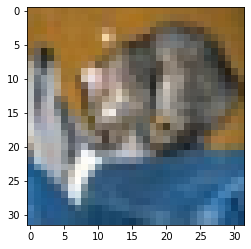

Model predicts a deer with 44% probability.  Ground truth: cat


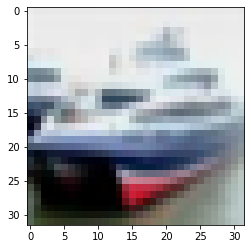

Model predicts a ship with 79% probability.  Ground truth: ship


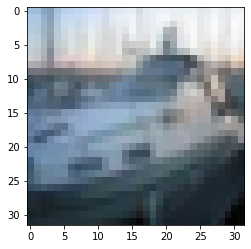

Model predicts a ship with 42% probability.  Ground truth: ship


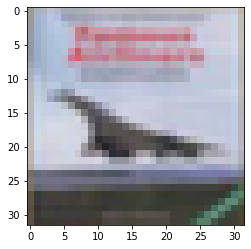

Model predicts a ship with 48% probability.  Ground truth: plane


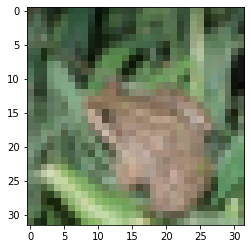

Model predicts a deer with 53% probability.  Ground truth: frog


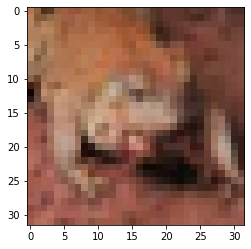

Model predicts a frog with 69% probability.  Ground truth: frog


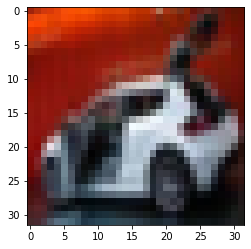

Model predicts a cat with 46% probability.  Ground truth: car


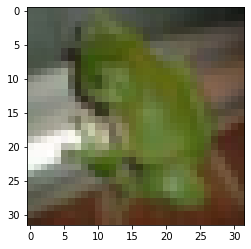

Model predicts a frog with 93% probability.  Ground truth: frog


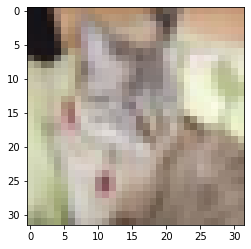

Model predicts a dog with 62% probability.  Ground truth: cat


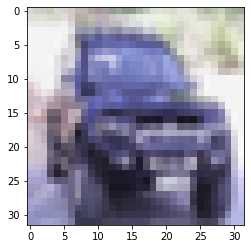

Model predicts a car with 96% probability.  Ground truth: car


In [46]:
# Get a single image
imgNum=9
images, labels = next(iter(testloader))

for imgNum in range(10):
    img = images[imgNum]
    
    img = img.unsqueeze(dim=0)
    # Do a forward pass
    model.eval()
    predLog = model(img)
    
    # Determine class prediction and print result
    predProb = torch.exp(predLog)
    prob, predClass = predProb.topk(1, dim=1)
    prob = prob.data.squeeze().tolist()
    predClass = predClass.squeeze().tolist()
    
    dI(img)
    print (f"Model predicts a {classes[predClass]} with {prob*100:.0f}% probability.  Ground truth: {classes[labels[imgNum]]}")

In [50]:

# taken from
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of the network on the 10000 test images: 51 %
Accuracy of plane : 50 %
Accuracy of   car : 74 %
Accuracy of  bird : 39 %
Accuracy of   cat : 32 %
Accuracy of  deer : 43 %
Accuracy of   dog : 47 %
Accuracy of  frog : 62 %
Accuracy of horse : 48 %
Accuracy of  ship : 75 %
Accuracy of truck : 46 %
